In [ ]:
#%load_ext cudf.pandas
import pandas as pd
import numpy as np
import os
import pickle
import gzip

In [ ]:
# read zip file from google drive
from google.colab import drive
drive.mount('/content/drive')#,timeout_ms=300000, force_remount=True, readonly=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#first_pass_data_brd4={'Xtr':Xtr,'ytr':ytr,'Xval':Xval,'yval':yval,'Xte':Xte,'yte':yte}

file_first = featstargs_file = "/content/drive/My Drive"+os.sep+"Belka_Data"+os.sep+"brd4_alone_balanced_trainTest.pkl"

with open(file_first,'rb') as f:
  data = pickle.load(f)

In [ ]:
'''

# Training data -- I am combining validation data here because the search will be using CV

# using morgan finger print features that showed better promise for BRD4 classification
Xtm = np.concatenate((data['Xtr'][1],data['Xval'][1]),axis=0)
Xtr = np.concatenate((data['Xtr'][2],data['Xval'][2]),axis=0)
ytr = np.concatenate((data['ytr'],data['yval']))

Xtem = data['Xte'][1]
Xte = data['Xte'][2]
yte = data['yte']

print(Xtr.shape)
'''
# Training data -- using validation data for pure testing

# using morgan finger print features that showed better promise for BRD4 classification
Xtm = data['Xtr'][1]
Xtr = data['Xtr'][2]
ytr =data['ytr']

Xtem = data['Xval'][1]
Xte =data['Xval'][2]
yte = data['yval']

'''
Xtem = data['Xte'][1]
Xte = data['Xte'][2]
yte = data['yte']
'''
print(Xtr.shape)

(2400, 1024)


## Logistic Regression
I try logistic regression with molecular features or top performing molecular and morgan features just to set a weak benchmark. I do not expect logistic to perform well given quantized features and binary morgan fingerprints.

##Random Forest model

I expect Random forest to be much better than logistic, given the type of features and the separability we noticed.  Only if both fail I will attempt neural network approaches and feature expansion methods.

## Gradient Boosting
To compare against the simple (logistic) and complex (random forest), I will train using XGBoost to see if that does better than random forest

## Feature Expansion
If all the above methods do not show promising performance, I will think about expanding the feature set and repeat the above approach

## Graph neural networks
If none of the above methods produce a desirable performance, I will switch to neural network approaches






In [ ]:
#Logistic regression
seed=2024
from sklearn.linear_model import LogisticRegressionCV as LCV
Xbest = np.concatenate((Xtm[:,[0,2,4]],Xtr[:,[191,562,843]]), axis=1)

lm = LCV(cv=10,random_state=seed,max_iter=100000)

lm.fit(Xbest,ytr)


LogisticRegressionCV(cv=10, max_iter=100000, random_state=2024)

In [ ]:
print(lm.coef_)

[[-0.12047917 -0.04087304  0.40914265  1.10164181  0.12685258  1.07251827]]


In [ ]:
from sklearn.metrics import roc_auc_score

modelPerformance =pd.DataFrame([],columns=['Model','#Parameters','Train Data points','Train positive fraction %','Train AUC',
                                           'Val Data points','Val positive fraction %','Val AUC'])
cm =lm.predict_proba(Xbest)





Xteb = np.concatenate((Xtem[:,[0,2,4]],Xte[:,[191,562,843]]),axis=1)
ct = lm.predict_proba(Xteb)
modelPerformance.loc[len(modelPerformance.index),:]=['Logistic_BPF',Xbest.shape[1]+1,
                                                     Xbest.shape[0],100*np.sum(ytr)/Xbest.shape[0],roc_auc_score(ytr,cm[:,1]),
                                                     Xteb.shape[0],100*np.sum(yte)/Xteb.shape[0],roc_auc_score(yte,ct[:,1])]

modelPerformance



,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942


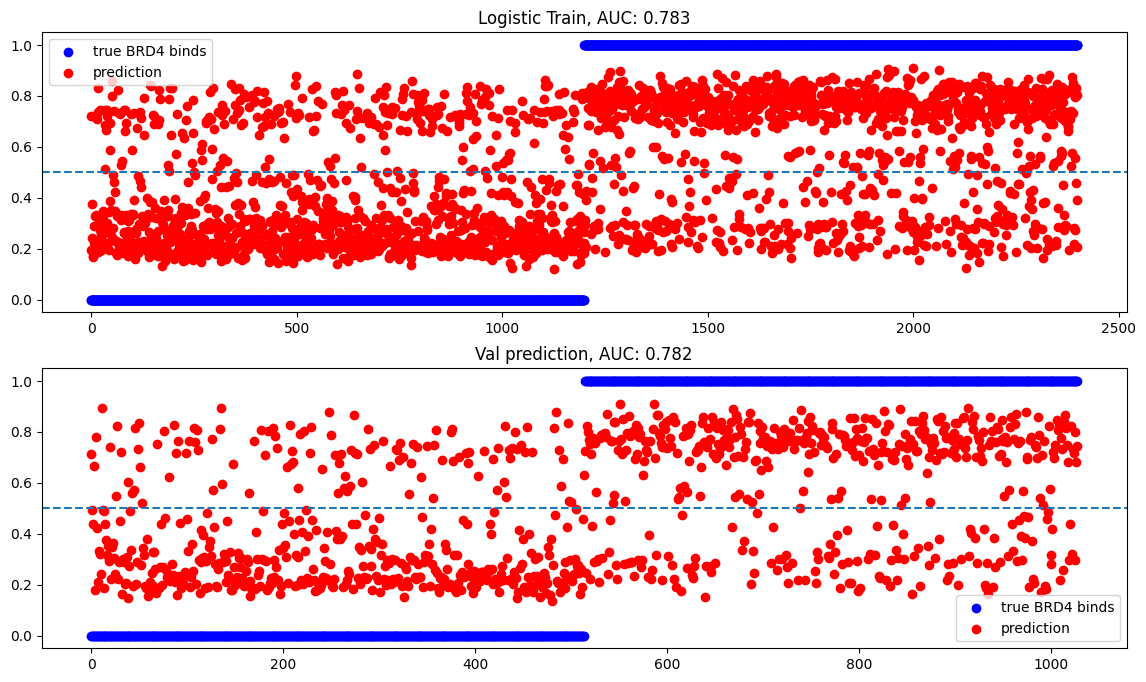

In [ ]:
from matplotlib import pyplot as plt

l11,l12,l21,l22=np.sum(ytr==0),np.sum(ytr==1),np.sum(yte==0),np.sum(yte==1)


ytru = np.concatenate((ytr[ytr==0],ytr[ytr==1]))
ctr =np.concatenate((cm[ytr==0,1],cm[ytr==1,1]))

yteu = np.concatenate((yte[yte==0],yte[yte==1]))
cte =np.concatenate((ct[yte==0,1],ct[yte==1,1]))


plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.scatter(np.arange(l11+l12),ytru,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l11+l12,linestyle='--')
plt.scatter(np.arange(l11+l12),ctr,color='r',label='prediction')
plt.title(f"Logistic Train, AUC: {np.round(modelPerformance.loc[0,'Train AUC'],3)}")
plt.legend()
plt.subplot(2,1,2)
plt.scatter(np.arange(l21+l22),yteu,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l21+l22,linestyle='--')
plt.scatter(np.arange(l21+l22),cte,color='r',label='prediction')
plt.title(f"Val prediction, AUC: {np.round(modelPerformance.loc[0,'Val AUC'],3)}")
plt.legend()
plt.show()

In [ ]:
auc=np.zeros((1024,))
for x in range(1024):
  ak = roc_auc_score(ytr,Xtr[:,x])
  auc[x]= ak if ak>0.5 else 1-ak

#a=np.arange(1024)
#np.sum[auc>0.6]
ids = np.where(auc>0.6)[0]
print(ids,len(ids))

array([  1,  21, 114, 117, 118, 137, 191, 312, 314, 364, 385, 423, 464,
       562, 618, 620, 632, 653, 690, 701, 843, 925, 935])

In [ ]:
ids = np.where(auc>0.6)[0]
print(ids,len(ids))

[  1  21 114 117 118 137 191 312 314 364 385 423 464 562 618 620 632 653
 690 701 843 925 935] 23


In [ ]:
from sklearn.linear_model import LogisticRegression as LR

lrm = LR(max_iter=100000)

from sklearn.feature_selection import RFECV

rfe = RFECV(lrm,cv=10)

rfe.fit(Xtr[:,auc>0.6],ytr)


RFECV(cv=10, estimator=LogisticRegression(max_iter=100000))

In [ ]:
idfs=ids[rfe.support_]
idfs

array([118, 191, 385, 925])

In [ ]:
Xbest = Xtr[:,idfs]

lm = LCV(cv=10,random_state=seed,max_iter=100000)

lm.fit(Xbest,ytr)

LogisticRegressionCV(cv=10, max_iter=100000, random_state=2024)

In [ ]:
cm =lm.predict_proba(Xbest)
Xteb = Xte[:,idfs]
ct = lm.predict_proba(Xteb)
modelPerformance.loc[len(modelPerformance.index),:]=['Logistic_SMF',Xbest.shape[1]+1,
                                                     Xbest.shape[0],100*np.sum(ytr)/Xbest.shape[0],roc_auc_score(ytr,cm[:,1]),
                                                     Xteb.shape[0],100*np.sum(yte)/Xteb.shape[0],roc_auc_score(yte,ct[:,1])]

modelPerformance

,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942
1,Logistic_SMF,5,2400,50.0,0.827317,1028,50.0,0.817344


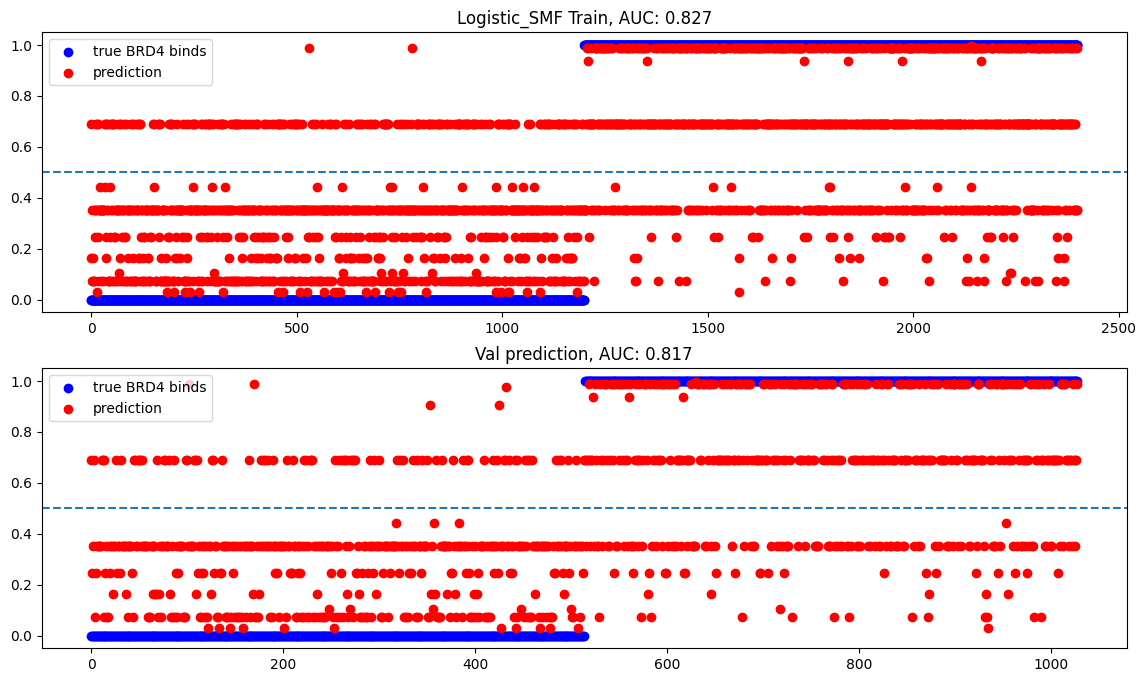

In [ ]:
l11,l12,l21,l22=np.sum(ytr==0),np.sum(ytr==1),np.sum(yte==0),np.sum(yte==1)


ytru = np.concatenate((ytr[ytr==0],ytr[ytr==1]))
ctr =np.concatenate((cm[ytr==0,1],cm[ytr==1,1]))

yteu = np.concatenate((yte[yte==0],yte[yte==1]))
cte =np.concatenate((ct[yte==0,1],ct[yte==1,1]))


plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.scatter(np.arange(l11+l12),ytru,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l11+l12,linestyle='--')
plt.scatter(np.arange(l11+l12),ctr,color='r',label='prediction')
plt.title(f"Logistic_SMF Train, AUC: {np.round(modelPerformance.loc[1,'Train AUC'],3)}")
plt.legend()
plt.subplot(2,1,2)
plt.scatter(np.arange(l21+l22),yteu,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l21+l22,linestyle='--')
plt.scatter(np.arange(l21+l22),cte,color='r',label='prediction')
plt.title(f"Val prediction, AUC: {np.round(modelPerformance.loc[1,'Val AUC'],3)}")
plt.legend()
plt.show()

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV as GCV

#min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,

params = {'n_estimators': [10,100,500,1000], 'max_depth': [1,2,3,4,5]}

rf = RFC(random_state=seed)#n_estimators = 100, max_depth = 3,
gs = GCV(rf,params,cv=10)

gs.fit(Xtr[:,idfs],ytr)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2024),
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [10, 100, 500, 1000]})

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV as GCV

In [ ]:
print(gs.best_score_,gs.best_estimator_)

0.765 RandomForestClassifier(max_depth=4, n_estimators=10, random_state=2024)


In [ ]:
rf = RFC(random_state=seed,n_estimators = 10, max_depth = 4)

rf.fit(Xbest,ytr)

RandomForestClassifier(max_depth=4, n_estimators=10, random_state=2024)

In [ ]:
cm =rf.predict_proba(Xbest)
Xteb = Xte[:,idfs]
ct = rf.predict_proba(Xteb)
modelPerformance.loc[len(modelPerformance.index),:]=['RF_SMF',Xbest.shape[1]+1,
                                                     Xbest.shape[0],100*np.sum(ytr)/Xbest.shape[0],roc_auc_score(ytr,cm[:,1]),
                                                     Xteb.shape[0],100*np.sum(yte)/Xteb.shape[0],roc_auc_score(yte,ct[:,1])]

modelPerformance

,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942
1,Logistic_SMF,5,2400,50.0,0.827317,1028,50.0,0.817344
2,RF_SMF,5,2400,50.0,0.827728,1028,50.0,0.820285


In [ ]:
ids

array([  1,  21, 114, 117, 118, 137, 191, 312, 314, 364, 385, 423, 464,
       562, 618, 620, 632, 653, 690, 701, 843, 925, 935])

In [ ]:
params = {'n_estimators': [10,100,500,1000,1500,2000], 'max_depth': [1,2,3,4,5,8,10,15]}

rf = RFC(random_state=seed)#n_estimators = 100, max_depth = 3,
gs = GCV(rf,params,cv=10)

gs.fit(Xtr[:,ids],ytr)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2024),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 8, 10, 15],
                         'n_estimators': [10, 100, 500, 1000, 1500, 2000]})

In [ ]:
print(gs.best_score_,gs.best_estimator_)

0.7895833333333333 RandomForestClassifier(max_depth=8, n_estimators=500, random_state=2024)


In [ ]:
rf = RFC(random_state=seed,n_estimators = 500, max_depth = 8)

rf.fit(Xtr[:,ids],ytr)

RandomForestClassifier(max_depth=8, n_estimators=500, random_state=2024)

In [ ]:
cm =rf.predict_proba(Xtr[:,ids])
Xteb = Xte[:,ids]
ct = rf.predict_proba(Xteb)
modelPerformance.loc[len(modelPerformance.index),:]=['RF_SBMF',len(ids),
                                                     Xbest.shape[0],100*np.sum(ytr)/Xbest.shape[0],roc_auc_score(ytr,cm[:,1]),
                                                     Xteb.shape[0],100*np.sum(yte)/Xteb.shape[0],roc_auc_score(yte,ct[:,1])]

modelPerformance

,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942
1,Logistic_SMF,5,2400,50.0,0.827317,1028,50.0,0.817344
2,RF_SMF,5,2400,50.0,0.827728,1028,50.0,0.820285
3,RF_SBMF,23,2400,50.0,0.884209,1028,50.0,0.864423


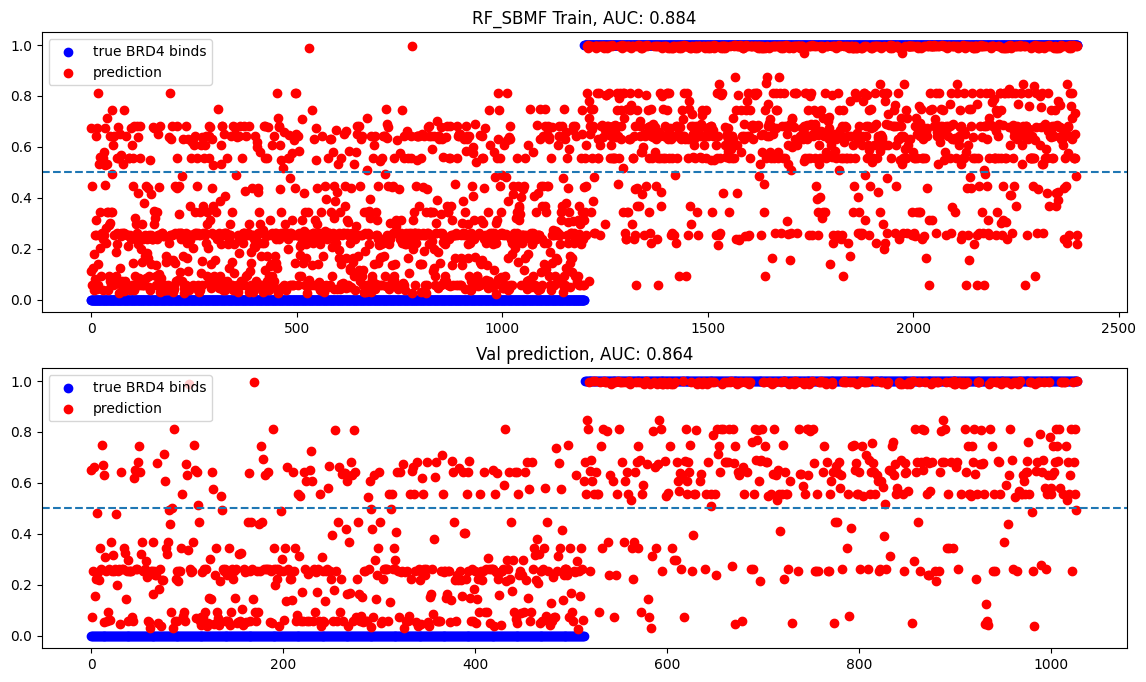

In [ ]:
l11,l12,l21,l22=np.sum(ytr==0),np.sum(ytr==1),np.sum(yte==0),np.sum(yte==1)


ytru = np.concatenate((ytr[ytr==0],ytr[ytr==1]))
ctr =np.concatenate((cm[ytr==0,1],cm[ytr==1,1]))

yteu = np.concatenate((yte[yte==0],yte[yte==1]))
cte =np.concatenate((ct[yte==0,1],ct[yte==1,1]))


plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.scatter(np.arange(l11+l12),ytru,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l11+l12,linestyle='--')
plt.scatter(np.arange(l11+l12),ctr,color='r',label='prediction')
plt.title(f"RF_SBMF Train, AUC: {np.round(modelPerformance.loc[3,'Train AUC'],3)}")
plt.legend()
plt.subplot(2,1,2)
plt.scatter(np.arange(l21+l22),yteu,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l21+l22,linestyle='--')
plt.scatter(np.arange(l21+l22),cte,color='r',label='prediction')
plt.title(f"Val prediction, AUC: {np.round(modelPerformance.loc[3,'Val AUC'],3)}")
plt.legend()
plt.show()

In [ ]:
seed=2024
rf = RFC(random_state=seed,n_estimators = 500, max_depth = 8)

rf.fit(Xtr,ytr)

cm =rf.predict_proba(Xtr)
Xteb = Xte
ct = rf.predict_proba(Xteb)
modelPerformance.loc[len(modelPerformance.index),:]=['RF_AllMF',(500,8),
                                                     Xtr.shape[0],100*np.sum(ytr)/Xbest.shape[0],roc_auc_score(ytr,cm[:,1]),
                                                     Xteb.shape[0],100*np.sum(yte)/Xteb.shape[0],roc_auc_score(yte,ct[:,1])]

modelPerformance

,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942
1,RF_AllMF,"(500, 8)",2400,50.0,0.974584,1028,50.0,0.947452


<Axes: >

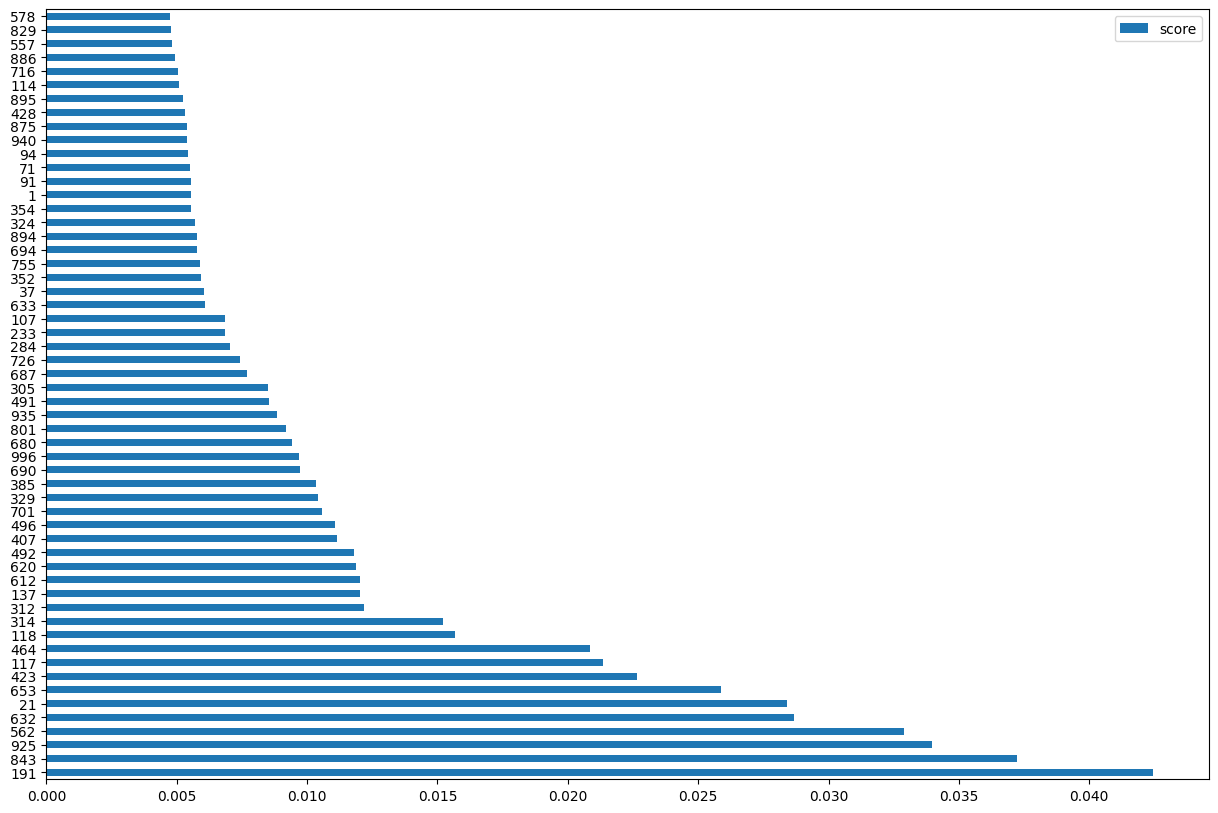

In [ ]:
keys = np.arange(1024)
values = rf.feature_importances_



data = pd.DataFrame(data=values, index=keys, columns=["score"])
data.score=-data.score.values
data=data.sort_values(by = "score", ascending=False)
data.score=-data.score.values
data.nlargest(56, columns="score").plot(kind='barh', figsize = (15,10)) ## plot top 40 features

In [ ]:
values=rf.feature_importances_
val=-np.sort(-values)
val[:10]

array([0.04246193, 0.03721662, 0.03396069, 0.03288414, 0.02868652,
       0.02840236, 0.02589172, 0.02266312, 0.02136598, 0.02083702])

In [ ]:
logval=np.log(val[val>0])

In [ ]:
for k in range(1024):
 rk = (np.linalg.norm(val[:k])/np.linalg.norm(val))**2
 if rk > 0.95:
  print(k)
  break


56


In [ ]:
np.linalg.norm(val)

0.11413591473780589

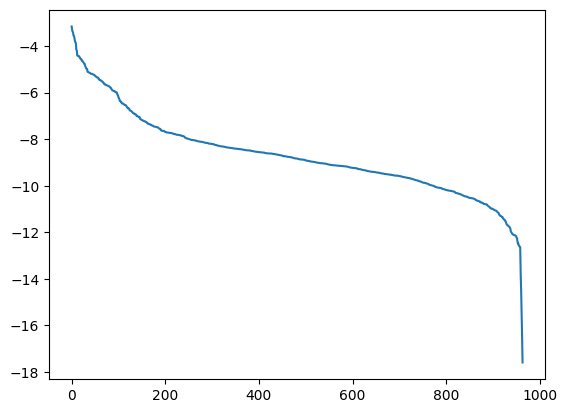

In [ ]:
import matplotlib.pyplot as plt
plt.plot(logval)
plt.show()

In [ ]:
val=np.log(values+1e-6)

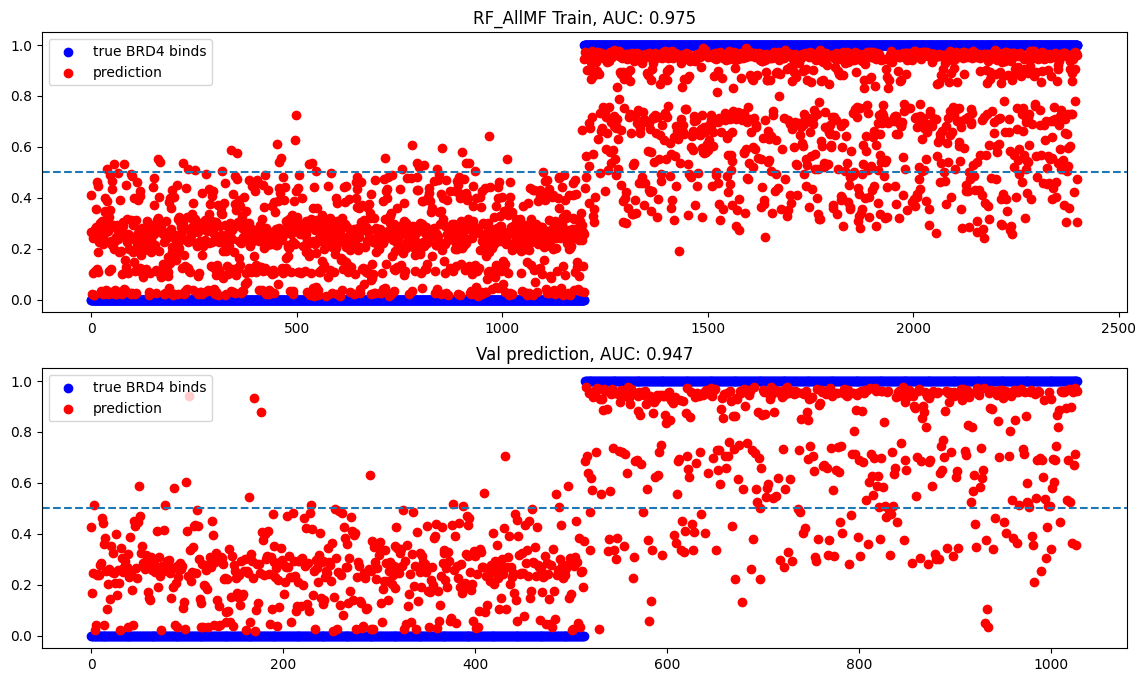

In [ ]:
l11,l12,l21,l22=np.sum(ytr==0),np.sum(ytr==1),np.sum(yte==0),np.sum(yte==1)


ytru = np.concatenate((ytr[ytr==0],ytr[ytr==1]))
ctr =np.concatenate((cm[ytr==0,1],cm[ytr==1,1]))

yteu = np.concatenate((yte[yte==0],yte[yte==1]))
cte =np.concatenate((ct[yte==0,1],ct[yte==1,1]))


plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.scatter(np.arange(l11+l12),ytru,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l11+l12,linestyle='--')
plt.scatter(np.arange(l11+l12),ctr,color='r',label='prediction')
plt.title(f"RF_AllMF Train, AUC: {np.round(modelPerformance.loc[16,'Train AUC'],3)}")
plt.legend()
plt.subplot(2,1,2)
plt.scatter(np.arange(l21+l22),yteu,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l21+l22,linestyle='--')
plt.scatter(np.arange(l21+l22),cte,color='r',label='prediction')
plt.title(f"Val prediction, AUC: {np.round(modelPerformance.loc[16,'Val AUC'],3)}")
plt.legend()
plt.show()

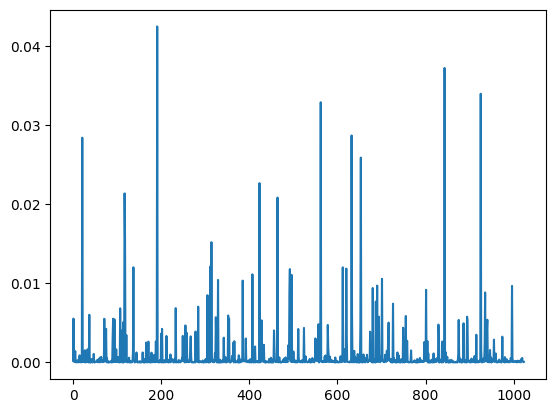

In [ ]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1024),rf.feature_importances_)
plt.show()

In [ ]:
isel=np.argsort(-rf.feature_importances_)

print(np.sum(rf.feature_importances_[isel[:375]]))
print(np.sum(rf.feature_importances_))

print(isel[:375])

0.9501506739762392
1.0
[ 191  843  925  562  632   21  653  423  117  464  118  314  312  137
  612  620  492  407  496  701  329  385  690  996  680  801  935  491
  305  687  726  284  233  107  633   37  352  755  694  894  324  354
    1   91   71   94  940  875  428  895  114  716  886  557  829  578
  652  255  749  524   75  202  511  112  939  456  278  674  258  200
  830  937  915  121  715  621  249  212  267  974   90  753  342  550
  392  955  555  758  804  366  188  838  171  797  364  934  166  325
  433  489  413  266  579  618  457   98   33  946  488   27  926  767
  712  638  554  841    5  500  845  136  158  736  144  178  322  806
  818  959  675   47  646  874  876  659  221  708  561  667  184  376
   15   36  739  573  362  580  911  361  607  842  698  528  571  257
  583  268  640  315  849   64  102  980  346  468  661  377  948  482
  595  827  127  512   61  175  449  283  787  656  993 1019  932  167
  543  549   77  728  575  695  367  138  247  904   1

In [ ]:
# after getting feature importances for 1024 morgan features -- fine tune the rf with 375 most important features that are predictive and cover >0.95 of feature importance score

iselect = isel[:56]
params = {'n_estimators': [10,100,500,1000,1500,2000,3000,5000], 'max_depth': [1,2,3,4,5,8]}

rf = RFC(random_state=seed)#n_estimators = 100, max_depth = 3,
gs = GCV(rf,params,cv=10)

gs.fit(Xtr[:,iselect],ytr)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2024),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 8],
                         'n_estimators': [10, 100, 500, 1000, 1500, 2000, 3000,
                                          5000]})

In [ ]:
print(gs.best_score_,gs.best_params_)

0.8816666666666666 {'max_depth': 8, 'n_estimators': 500}


In [ ]:
iselect = isel[:375]

In [ ]:
from sklearn.metrics import roc_auc_score
rf = RFC(random_state=seed,n_estimators = 500, max_depth = 6)

rf.fit(Xtr[:,iselect],ytr)

cm =rf.predict_proba(Xtr[:,iselect])

ct = rf.predict_proba(Xte[:,iselect])
modelPerformance =pd.DataFrame([],columns=['Model','#Parameters','Train Data points','Train positive fraction %','Train AUC',
                                           'Val Data points','Val positive fraction %','Val AUC'])
modelPerformance.loc[len(modelPerformance.index),:]=['RF_SelMF','375 F (500,6)',
                                                     Xtr.shape[0],100*np.sum(ytr)/Xtr.shape[0],roc_auc_score(ytr,cm[:,1]),
                                                     Xte.shape[0],100*np.sum(yte)/Xte.shape[0],roc_auc_score(yte,ct[:,1])]

modelPerformance

,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,RF_SelMF,"375 F (500,6)",2400,50.0,0.954887,1028,50.0,0.93872


<Axes: >

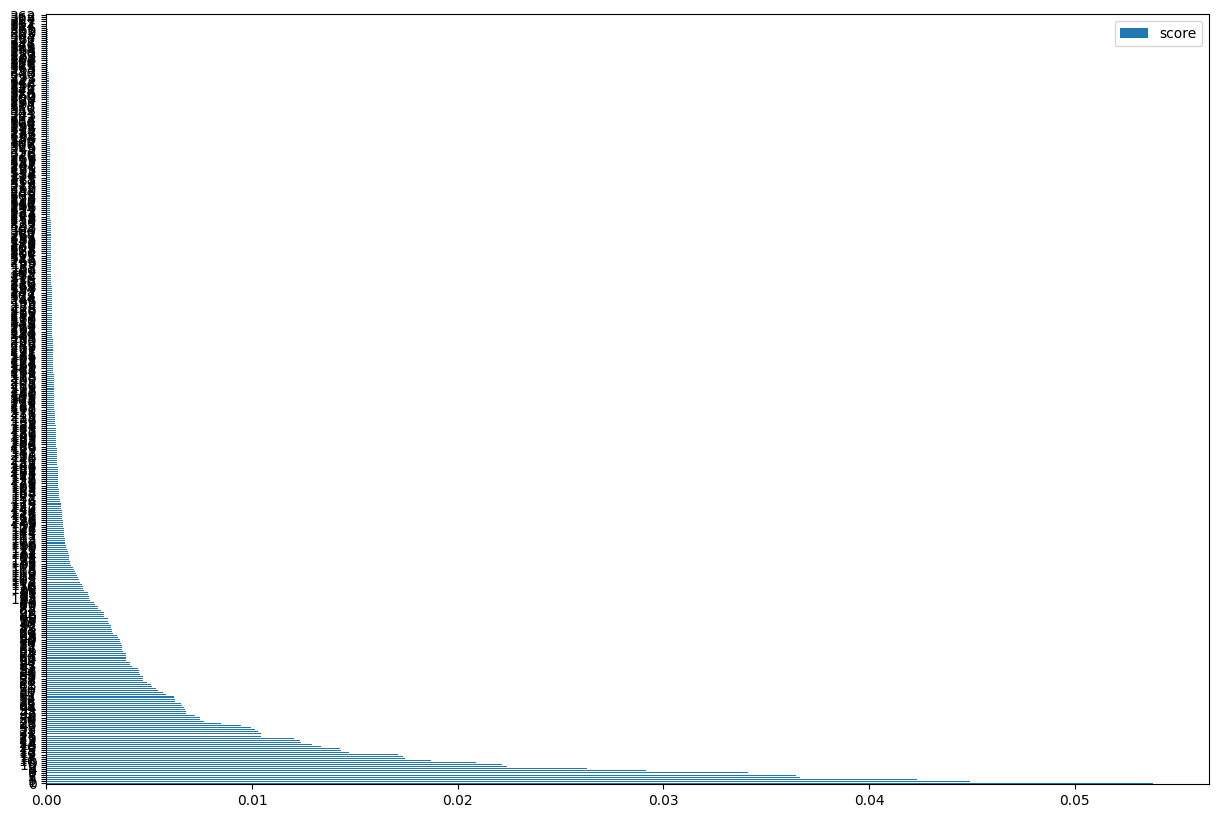

In [ ]:
keys = np.arange(375)
values = rf.feature_importances_



data = pd.DataFrame(data=values, index=keys, columns=["score"])
data.score=-data.score.values
data=data.sort_values(by = "score", ascending=False)
data.score=-data.score.values
data.nlargest(375, columns="score").plot(kind='barh', figsize = (15,10)) ## plot top 40 features

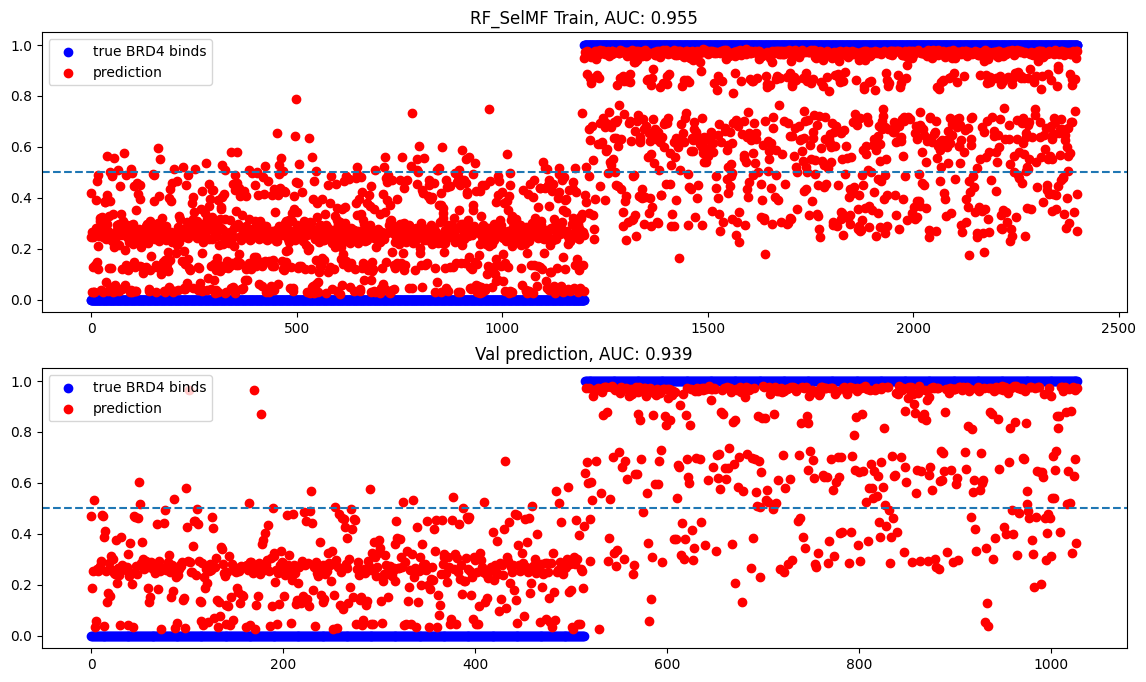

In [ ]:
l11,l12,l21,l22=np.sum(ytr==0),np.sum(ytr==1),np.sum(yte==0),np.sum(yte==1)


ytru = np.concatenate((ytr[ytr==0],ytr[ytr==1]))
ctr =np.concatenate((cm[ytr==0,1],cm[ytr==1,1]))

yteu = np.concatenate((yte[yte==0],yte[yte==1]))
cte =np.concatenate((ct[yte==0,1],ct[yte==1,1]))


plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.scatter(np.arange(l11+l12),ytru,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l11+l12,linestyle='--')
plt.scatter(np.arange(l11+l12),ctr,color='r',label='prediction')
plt.title(f"RF_SelMF Train, AUC: {np.round(modelPerformance.loc[0,'Train AUC'],3)}")
plt.legend()
plt.subplot(2,1,2)
plt.scatter(np.arange(l21+l22),yteu,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l21+l22,linestyle='--')
plt.scatter(np.arange(l21+l22),cte,color='r',label='prediction')
plt.title(f"Val prediction, AUC: {np.round(modelPerformance.loc[0,'Val AUC'],3)}")
plt.legend()
plt.show()

In [ ]:
import pickle
model_file = "/content/drive/My Drive"+os.sep+"Belka_Data"+os.sep

data={'rf_model':rf,'info': 'Trained on Xtr from brd4_alone_balanced_trainTest.pkl and validated on Xval morgan finger prints','selected_features':iselect}
with open(model_file+"rf_model_brd4.pkl", "wb") as f:
  pickle.dump(data, f)

In [ ]:
model_file = "/content/drive/My Drive"+os.sep+"Belka_Data"+os.sep+"rf_model_brd4.pkl"
with open(model_file, "rb") as f:
  data = pickle.load(f)

In [ ]:
model_file

'/content/drive/My Drive/Belka_Data/rf_model_brd4.pkl'

In [ ]:
params = {'n_estimators': [10,100,500,1000,1500,2000], 'max_depth': [1,2,3,4,5,8,10,15]}

rf = RFC(random_state=seed)#n_estimators = 100, max_depth = 3,
gs = GCV(rf,params,cv=10)

Xtotr=np.concatenate((Xtm,Xtr),axis=1)
gs.fit(Xtotr,ytr)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2024),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 8, 10, 15],
                         'n_estimators': [10, 100, 500, 1000, 1500, 2000]})

In [ ]:
print(gs.best_score_,gs.best_estimator_)

0.9029166666666668 RandomForestClassifier(max_depth=15, random_state=2024)


In [ ]:
gs.best_params_

{'max_depth': 15, 'n_estimators': 100}

In [ ]:
params = {'n_estimators': [10,100,500,1000,1500,2000,3000,5000]}#, 'max_depth': [1,2,3,4,5,8,10,15]}

rf = RFC(random_state=seed, max_depth=8)#n_estimators = 100, max_depth = 3,
gs = GCV(rf,params,cv=10)

Xtotr=np.concatenate((Xtm,Xtr),axis=1)
gs.fit(Xtotr,ytr)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=8, random_state=2024),
             param_grid={'n_estimators': [10, 100, 500, 1000, 1500, 2000, 3000,
                                          5000]})

In [ ]:
gs.best_params_

{'n_estimators': 100}

In [ ]:
rf = RFC(random_state=seed,n_estimators = 100, max_depth = 8)

rf.fit(Xtotr,ytr)

cm =rf.predict_proba(Xtotr)
Xteb = np.concatenate((Xtem,Xte),axis=1)
ct = rf.predict_proba(Xteb)
modelPerformance.loc[len(modelPerformance.index),:]=['RF_All',1031,
                                                     Xbest.shape[0],100*np.sum(ytr)/Xbest.shape[0],roc_auc_score(ytr,cm[:,1]),
                                                     Xteb.shape[0],100*np.sum(yte)/Xteb.shape[0],roc_auc_score(yte,ct[:,1])]

modelPerformance

,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942
1,Logistic_SMF,5,2400,50.0,0.827317,1028,50.0,0.817344
2,RF_SMF,5,2400,50.0,0.827728,1028,50.0,0.820285
3,RF_SBMF,23,2400,50.0,0.884209,1028,50.0,0.864423
4,RF_AllMF,1024,2400,50.0,0.974584,1028,50.0,0.947452
5,RF_All,1031,2400,50.0,0.999171,1028,50.0,0.96484
6,RF_All,1031,2400,50.0,0.97625,1028,50.0,0.947448
7,RF_All,1031,2400,50.0,0.99999,1028,50.0,0.965768
8,RF_All,1031,2400,50.0,1.0,1028,50.0,0.968291
9,RF_All,1031,2400,50.0,0.987049,1028,50.0,0.955514


In [ ]:
auc=np.zeros((1031,))
for x in range(1031):
  ak = roc_auc_score(ytr,Xtotr[:,x])
  auc[x]= ak if ak>0.5 else 1-ak

ids = np.where(auc>0.55)[0]
print(ids,len(ids))

[   0    2    8   28   43   78   82  119  121  124  125  144  173  185
  195  198  240  265  285  291  312  319  321  336  349  371  392  414
  420  430  435  440  471  496  498  499  503  518  557  564  569  619
  625  627  628  639  659  660  681  687  694  697  701  708  723  733
  743  762  804  808  836  837  850  882  893  922  932  941  942  947
  962  981 1003] 73


In [ ]:
params = {'n_estimators': [10,100,500,1000,1500,2000,3000,5000], 'max_depth': [1,2,3,4,5,8,10,15,20]}

rf = RFC(random_state=seed)#n_estimators = 100, max_depth = 3,
gs = GCV(rf,params,cv=10)

#Xtotr=np.concatenate((Xtm,Xtr),axis=1)
gs.fit(Xtotr[:,ids],ytr)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2024),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 8, 10, 15, 20],
                         'n_estimators': [10, 100, 500, 1000, 1500, 2000, 3000,
                                          5000]})

In [ ]:
gs.best_params_

{'max_depth': 20, 'n_estimators': 1000}

In [ ]:
rf = RFC(random_state=seed,n_estimators = 5000, max_depth = 4)

rf.fit(Xtotr[:,ids],ytr)

cm =rf.predict_proba(Xtotr[:,ids])
Xteb = np.concatenate((Xtem,Xte),axis=1)
ct = rf.predict_proba(Xteb[:,ids])
modelPerformance.loc[len(modelPerformance.index),:]=['RF_SelAll',len(ids),
                                                     Xtotr.shape[0],100*np.sum(ytr)/Xtotr.shape[0],roc_auc_score(ytr,cm[:,1]),
                                                     Xteb.shape[0],100*np.sum(yte)/Xteb.shape[0],roc_auc_score(yte,ct[:,1])]

modelPerformance

,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942
1,Logistic_SMF,5,2400,50.0,0.827317,1028,50.0,0.817344
2,RF_SMF,5,2400,50.0,0.827728,1028,50.0,0.820285
3,RF_SBMF,23,2400,50.0,0.884209,1028,50.0,0.864423
4,RF_AllMF,1024,2400,50.0,0.974584,1028,50.0,0.947452
5,RF_All,1031,2400,50.0,0.999171,1028,50.0,0.96484
6,RF_All,1031,2400,50.0,0.97625,1028,50.0,0.947448
7,RF_All,1031,2400,50.0,0.99999,1028,50.0,0.965768
8,RF_All,1031,2400,50.0,1.0,1028,50.0,0.968291
9,RF_All,1031,2400,50.0,0.987049,1028,50.0,0.955514
